
**<font size = 6> Hotel Stay Growth Insights - Unveiling Opportunities </font>**

**Problem Statement**

Explaining and quantifying: 
1. What the data suggests in terms of the **key drivers** of Net Room Nights performance
2. Where the opportunities in **growing Room Nights** may lie.

### **Import Pre-requisites**

In [31]:
import pandas as pd
import numpy as np 
from scipy import stats
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import math

pd.set_option('display.max_columns', 100)

### **Import Dataset**

**Description**: The dataset is for a three year duration from Jan 2017 to Dec 2019. 
* Date

Categorical Columns
* Geographic Region
* Platform
* Marketing Channel	

Numerical Columns
* Visits
* Qualified Shoppers	
* Bounced Visits	
* Gross Orders	
* Net Orders	
* Net Room Nights:

In [32]:
dataset_path  = r"/Users/addltariq/Marketing_Analytics_Insights_Case_Study_Dataset.csv"
df = pd.read_csv(dataset_path)

### **Dataset Review**

In [33]:
# Filter rows where 'Date' format is not '%d-%m-%Y' ("Removing 29-02-2017 rows because it is an invalid date, 2017 not a leap year")
dataset = df[df['Date'].str.match(r'\d{2}/\d{2}/\d{4}')]
dataset.loc[:,"Date"] = pd.to_datetime(dataset['Date'], format='%d/%m/%Y')

print("Dataset rows and columns:", dataset.shape)
print("Dataset Feature data types:")
print(dataset.dtypes)

Dataset rows and columns: (87776, 10)
Dataset Feature data types:
Date                  datetime64[ns]
Geographic Region             object
Platform                      object
Marketing Channel             object
Visits                         int64
Qualified Shoppers             int64
Bounced Visits                 int64
Gross Orders                   int64
Net Orders                     int64
Net Room Nights                int64
dtype: object


/Users/addltariq/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [34]:
dataset.head()

,Date,Geographic Region,Platform,Marketing Channel,Visits,Qualified Shoppers,Bounced Visits,Gross Orders,Net Orders,Net Room Nights
0,2017-01-01,Geo Region 1,Desktop,Channel 1,3011,1878,811,1139,957,1848
1,2017-01-01,Geo Region 1,Desktop,Channel 2,119684,82504,26541,12489,10369,19897
2,2017-01-01,Geo Region 1,Desktop,Channel 3,25612,11828,7398,1399,1139,2257
3,2017-01-01,Geo Region 1,Desktop,Channel 4,3115,1463,1393,69,50,81
4,2017-01-01,Geo Region 1,Desktop,Channel 5,5657,4307,1346,641,517,921


In [35]:
dataset.describe()

,Visits,Qualified Shoppers,Bounced Visits,Gross Orders,Net Orders,Net Room Nights
count,87776.000000,87776.000000,87776.000000,87776.000000,87776.000000,87776.000000
mean,27811.110736,12942.688081,12502.429821,1165.088168,940.076980,1994.250957
std,42476.870217,21942.037066,23045.713549,3159.710456,2551.822861,5502.335941
min,1.000000,0.000000,0.000000,0.000000,-100.000000,-267.000000
25%,4161.750000,1723.750000,1571.000000,75.000000,59.000000,129.000000
50%,12306.000000,5811.500000,4924.000000,329.000000,261.000000,555.000000
75%,33670.000000,15217.250000,13952.000000,1012.000000,807.000000,1659.000000
max,683764.000000,280919.000000,546089.000000,38354.000000,35318.000000,79141.000000


In [36]:
pd.value_counts(dataset['Geographic Region'])

Geo Region 1    21944
Geo Region 2    21944
Geo Region 3    21944
Geo Region 4    21944
Name: Geographic Region, dtype: int64

In [37]:
pd.value_counts(dataset['Platform'])

Desktop    43888
Mobile     43888
Name: Platform, dtype: int64

In [38]:
pd.value_counts(dataset['Marketing Channel'])

Channel 1     8776
Channel 2     8776
Channel 3     8776
Channel 4     8776
Channel 5     8776
Channel 6     8776
Channel 7     8776
Channel 8     8776
Channel 9     8776
Channel 10    8776
Channel 11      16
Name: Marketing Channel, dtype: int64

### **Feature Engineering**

We are required to form some derived metrics for our regression approach to the problem

* Day, Month, Year, Day_of_week,  Month_year, Weekay, Weekend, Week number column formation from Date
* Potential rate = Qualified Shoppers/ Visits
* Order rate = Gross Order/Qualified Shoppers
* Buying rate = Net Orders/Gross Orders
* Occupancy rate = Net room Nights / Net Orders
* Bounce rate = (Bounce Visits/ Visits)
* Cancelled Orders = |Gross Orders - Net Orders|
* Net_orders_QSV = Net Orders/Qualified Shoppers.

In [39]:
up_dataset = dataset.copy()

# Funnel Metrics
up_dataset.loc[:,"Cancelled_Orders"] = abs(up_dataset["Gross Orders"] - up_dataset["Net Orders"])
up_dataset.loc[:,"Potential_rate"] =  round((up_dataset["Qualified Shoppers"] / up_dataset["Visits"]),3)

up_dataset.loc[:,"Order_rate"] =  round((up_dataset["Gross Orders"] / up_dataset["Qualified Shoppers"]),3)
up_dataset["Order_rate"] = abs(up_dataset["Order_rate"].where((up_dataset["Gross Orders"] != 0) & (up_dataset["Qualified Shoppers"] != 0), 0))

up_dataset.loc[:,"Buying_rate"] =  round((up_dataset["Net Orders"] / up_dataset["Gross Orders"]),3)
up_dataset["Buying_rate"] = abs(up_dataset["Buying_rate"].where((up_dataset["Net Orders"] != 0) & (up_dataset["Gross Orders"] != 0), 0))

up_dataset.loc[:,"Occupancy_rate"] =  round((up_dataset["Net Room Nights"] / up_dataset["Net Orders"]),3)
up_dataset["Occupancy_rate"] = abs(up_dataset["Occupancy_rate"].where((up_dataset["Net Room Nights"] != 0) & (up_dataset["Net Orders"] != 0), 0))

up_dataset.loc[:,"Bounce_rate"] =  round((up_dataset["Bounced Visits"] / up_dataset["Visits"]),3)

up_dataset.loc[:,"Cancellation_rate"] =  round((up_dataset["Cancelled_Orders"] / up_dataset["Gross Orders"]),3)
up_dataset["Cancellation_rate"] = abs(up_dataset["Cancellation_rate"].where((up_dataset["Cancelled_Orders"] != 0) & (up_dataset["Gross Orders"] != 0), 0))

up_dataset.loc[:,"Net_orders_QSV"] =  round(up_dataset["Net Orders"]/up_dataset["Qualified Shoppers"],3)
up_dataset["Net_orders_QSV"] = abs(up_dataset["Net_orders_QSV"].where((up_dataset["Qualified Shoppers"] != 0) & (up_dataset["Net Orders"] != 0), 0))

In [40]:
up_dataset.head()

,Date,Geographic Region,Platform,Marketing Channel,Visits,Qualified Shoppers,Bounced Visits,Gross Orders,Net Orders,Net Room Nights,Cancelled_Orders,Potential_rate,Order_rate,Buying_rate,Occupancy_rate,Bounce_rate,Cancellation_rate,Net_orders_QSV
0,2017-01-01,Geo Region 1,Desktop,Channel 1,3011,1878,811,1139,957,1848,182,0.624,0.606,0.840,1.931,0.269,0.160,0.510
1,2017-01-01,Geo Region 1,Desktop,Channel 2,119684,82504,26541,12489,10369,19897,2120,0.689,0.151,0.830,1.919,0.222,0.170,0.126
2,2017-01-01,Geo Region 1,Desktop,Channel 3,25612,11828,7398,1399,1139,2257,260,0.462,0.118,0.814,1.982,0.289,0.186,0.096
3,2017-01-01,Geo Region 1,Desktop,Channel 4,3115,1463,1393,69,50,81,19,0.470,0.047,0.725,1.620,0.447,0.275,0.034
4,2017-01-01,Geo Region 1,Desktop,Channel 5,5657,4307,1346,641,517,921,124,0.761,0.149,0.807,1.781,0.238,0.193,0.120


In [41]:
up_dataset.describe()

,Visits,Qualified Shoppers,Bounced Visits,Gross Orders,Net Orders,Net Room Nights,Cancelled_Orders,Potential_rate,Order_rate,Buying_rate,Occupancy_rate,Bounce_rate,Cancellation_rate,Net_orders_QSV
count,87776.000000,87776.000000,87776.000000,87776.000000,87776.000000,87776.000000,87776.000000,87776.000000,87776.000000,87776.000000,87776.000000,87776.000000,87776.000000,87776.000000
mean,27811.110736,12942.688081,12502.429821,1165.088168,940.076980,1994.250957,225.011188,0.482624,0.092148,0.788066,2.194265,0.444955,0.206622,0.074808
std,42476.870217,21942.037066,23045.713549,3159.710456,2551.822861,5502.335941,620.273324,0.180447,0.112658,0.134851,0.786722,0.166833,0.137474,0.097569
min,1.000000,0.000000,0.000000,0.000000,-100.000000,-267.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4161.750000,1723.750000,1571.000000,75.000000,59.000000,129.000000,14.000000,0.373000,0.031000,0.753000,1.828000,0.319000,0.148000,0.024000
50%,12306.000000,5811.500000,4924.000000,329.000000,261.000000,555.000000,58.000000,0.474000,0.052000,0.806000,2.135000,0.434000,0.193000,0.042000
75%,33670.000000,15217.250000,13952.000000,1012.000000,807.000000,1659.000000,203.000000,0.619000,0.119000,0.851000,2.480250,0.532000,0.245000,0.094000
max,683764.000000,280919.000000,546089.000000,38354.000000,35318.000000,79141.000000,9346.000000,0.913000,5.538000,7.000000,73.000000,1.000000,8.000000,4.154000


In [42]:
# Time based Metrics
up_dataset.loc[:,'Day'] = up_dataset['Date'].dt.day
up_dataset.loc[:,'Month'] = up_dataset['Date'].dt.month
up_dataset.loc[:,'Quarter'] = up_dataset['Date'].dt.quarter
up_dataset.loc[:,'Year'] = up_dataset['Date'].dt.year
up_dataset.loc[:,'Month_year'] = up_dataset['Date'].dt.strftime('%m-%Y')
up_dataset.loc[:,'Day_of_week'] = up_dataset['Date'].dt.strftime('%A')
up_dataset.loc[:,'Day_type'] = up_dataset['Date'].dt.dayofweek.map({0: 'weekday', 1: 'weekday', 2: 'weekday', 3: 'weekday', 4: 'weekday', 5: 'weekend', 6: 'weekend'})
up_dataset.loc[:,'Week_number'] = up_dataset['Date'].dt.isocalendar().week

up_dataset = up_dataset.sort_values(by='Date')
earliest_date = up_dataset['Date'].min()
up_dataset['Day_Number'] = (up_dataset['Date'] - earliest_date).dt.days

In [43]:
up_dataset.head()

,Date,Geographic Region,Platform,Marketing Channel,Visits,Qualified Shoppers,Bounced Visits,Gross Orders,Net Orders,Net Room Nights,Cancelled_Orders,Potential_rate,Order_rate,Buying_rate,Occupancy_rate,Bounce_rate,Cancellation_rate,Net_orders_QSV,Day,Month,Quarter,Year,Month_year,Day_of_week,Day_type,Week_number,Day_Number
0,2017-01-01,Geo Region 1,Desktop,Channel 1,3011,1878,811,1139,957,1848,182,0.624,0.606,0.840,1.931,0.269,0.160,0.510,1,1,1,2017,01-2017,Sunday,weekend,52,0
57,2017-01-01,Geo Region 3,Mobile,Channel 8,7204,3853,3348,253,214,431,39,0.535,0.066,0.846,2.014,0.465,0.154,0.056,1,1,1,2017,01-2017,Sunday,weekend,52,0
56,2017-01-01,Geo Region 3,Mobile,Channel 7,23309,12049,9525,287,243,433,44,0.517,0.024,0.847,1.782,0.409,0.153,0.020,1,1,1,2017,01-2017,Sunday,weekend,52,0
55,2017-01-01,Geo Region 3,Mobile,Channel 6,12127,5566,5783,82,70,117,12,0.459,0.015,0.854,1.671,0.477,0.146,0.013,1,1,1,2017,01-2017,Sunday,weekend,52,0
54,2017-01-01,Geo Region 3,Mobile,Channel 5,1199,924,272,21,19,31,2,0.771,0.023,0.905,1.632,0.227,0.095,0.021,1,1,1,2017,01-2017,Sunday,weekend,52,0


In [44]:
len(up_dataset.columns)

27

In [45]:
up_dataset = up_dataset[["Date",	"Geographic Region",	"Platform",	"Marketing Channel"	,"Visits",	"Qualified Shoppers",	"Bounced Visits",	"Gross Orders", 	"Net Orders", 	"Net Room Nights",
	"Cancelled_Orders",	"Potential_rate",	"Order_rate",	"Buying_rate",	"Occupancy_rate",	"Bounce_rate",	"Cancellation_rate",	"Net_orders_QSV",
     	"Day",	"Month",	"Quarter",	"Year",	"Month_year",	"Day_of_week",	"Day_type",	"Week_number",	"Day_Number"]]


In [46]:
len(up_dataset.columns)

27

#### **Check Relationship b/w Features and Response**

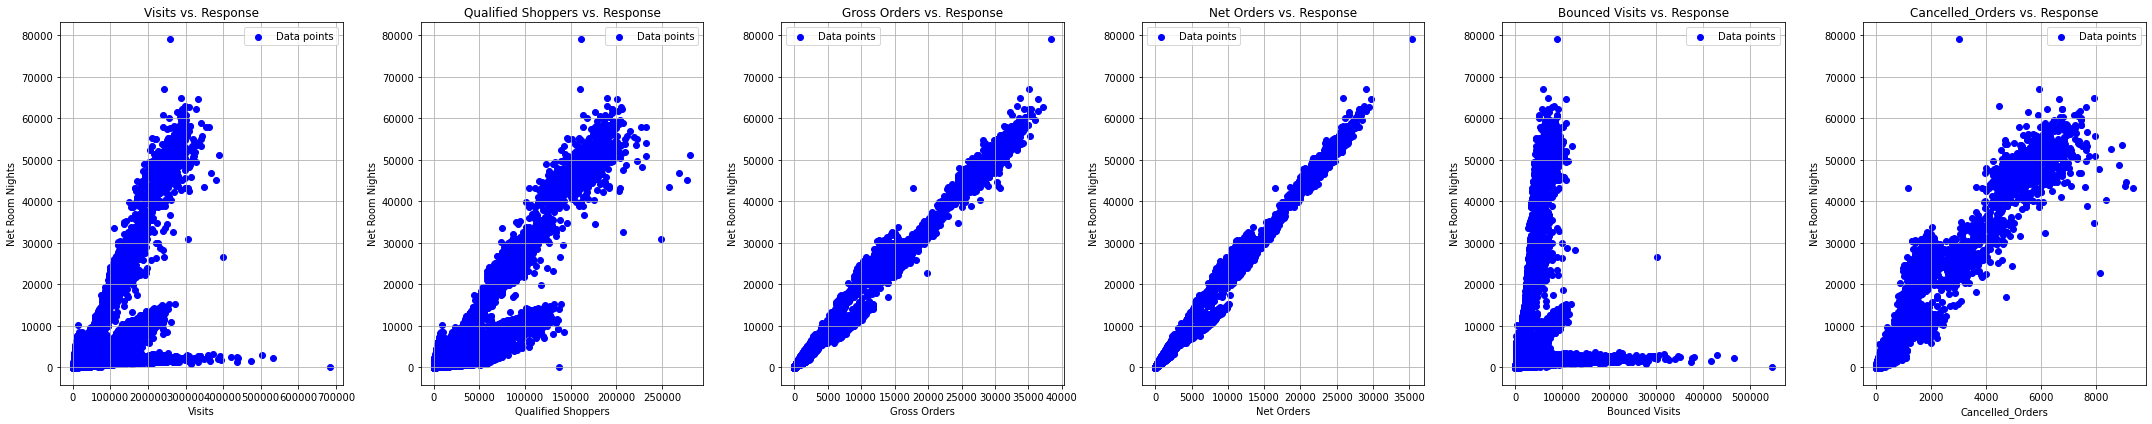

In [17]:
features = {
    'Visits': up_dataset["Visits"],
    'Qualified Shoppers': up_dataset["Qualified Shoppers"],
    'Gross Orders': up_dataset["Gross Orders"],
    'Net Orders': up_dataset["Net Orders"],
    'Bounced Visits': up_dataset["Bounced Visits"],
    'Cancelled_Orders': up_dataset["Cancelled_Orders"],
}

response = up_dataset["Net Room Nights"]

# Create a grid of multiple charts
fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(30, 6))

# Plot each feature-response relationship
for i, (feature_name, feature_values) in enumerate(features.items()):
    axes[i].scatter(feature_values, response, label='Data points', color='blue')
    axes[i].set_xlabel(feature_name)
    axes[i].set_ylabel('Net Room Nights')
    axes[i].set_title(f'{feature_name} vs. Response')
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.show()

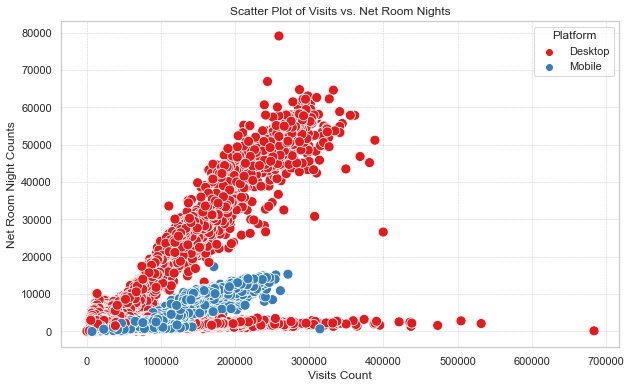

In [57]:
sns.set(style="whitegrid")

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=up_dataset, x="Visits", y="Net Room Nights", hue="Platform", palette="Set1", s=100)
scatter.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add grid lines for both major and minor ticks
plt.xlabel("Visits Count")
plt.ylabel("Net Room Night Counts")
plt.title("Scatter Plot of Visits vs. Net Room Nights")
plt.legend(title="Platform")
plt.show()

In [ ]:
mobile = up_dataset[up_dataset['Platform']=="Mobile"]
desktop = up_dataset[up_dataset['Platform']=="Desktop"]

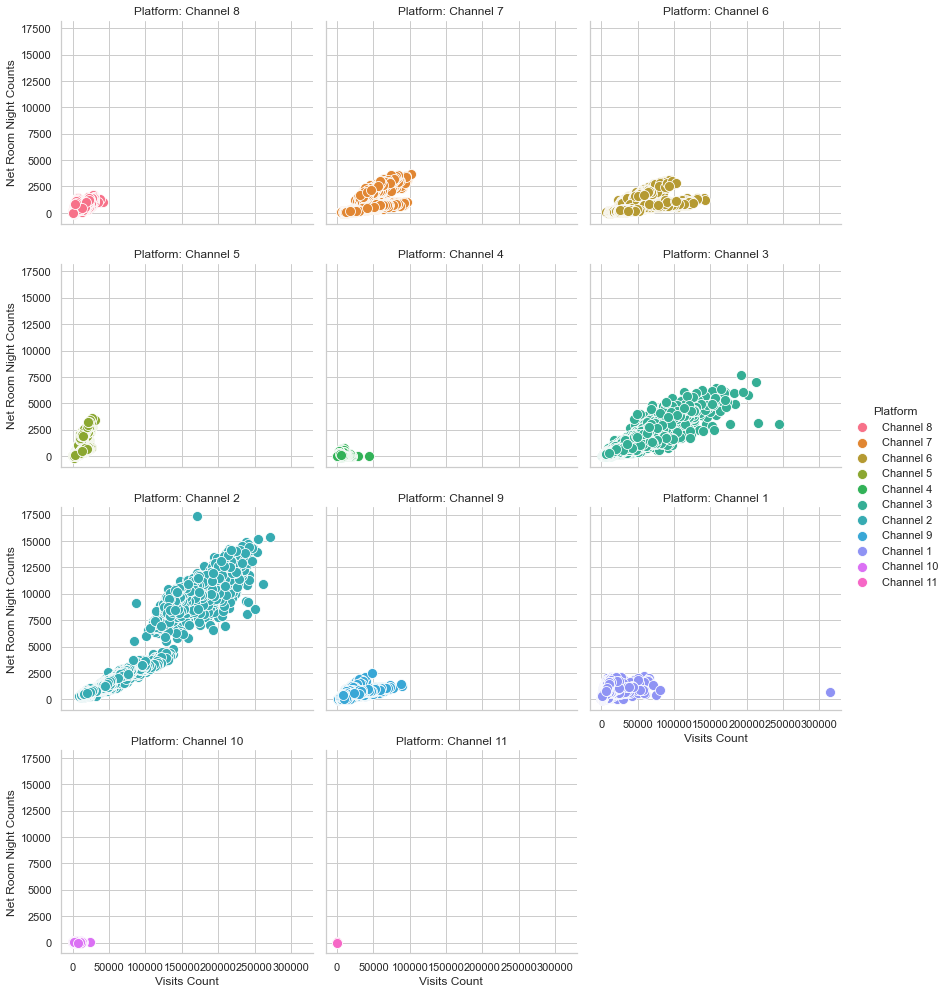

In [52]:
data = {
    "Visits Count": mobile["Visits"],
    "Net Room Night Counts": mobile["Net Room Nights"],
    "Platform": mobile["Marketing Channel"]
}

df = pd.DataFrame(data)
sns.set(style="whitegrid")

# Create separate scatter plots for each platform using facet_grid
g = sns.FacetGrid(df, col="Platform", hue="Platform", col_wrap=3, height=4)
g.map(sns.scatterplot, "Visits Count", "Net Room Night Counts", s=100)
g.set_axis_labels("Visits Count", "Net Room Night Counts")
g.set_titles("Platform: {col_name}")
g.add_legend(title="Platform")

# Adjust plot spacing
plt.subplots_adjust(top=0.85)  # Make room for the title

# Show the plots
plt.show()


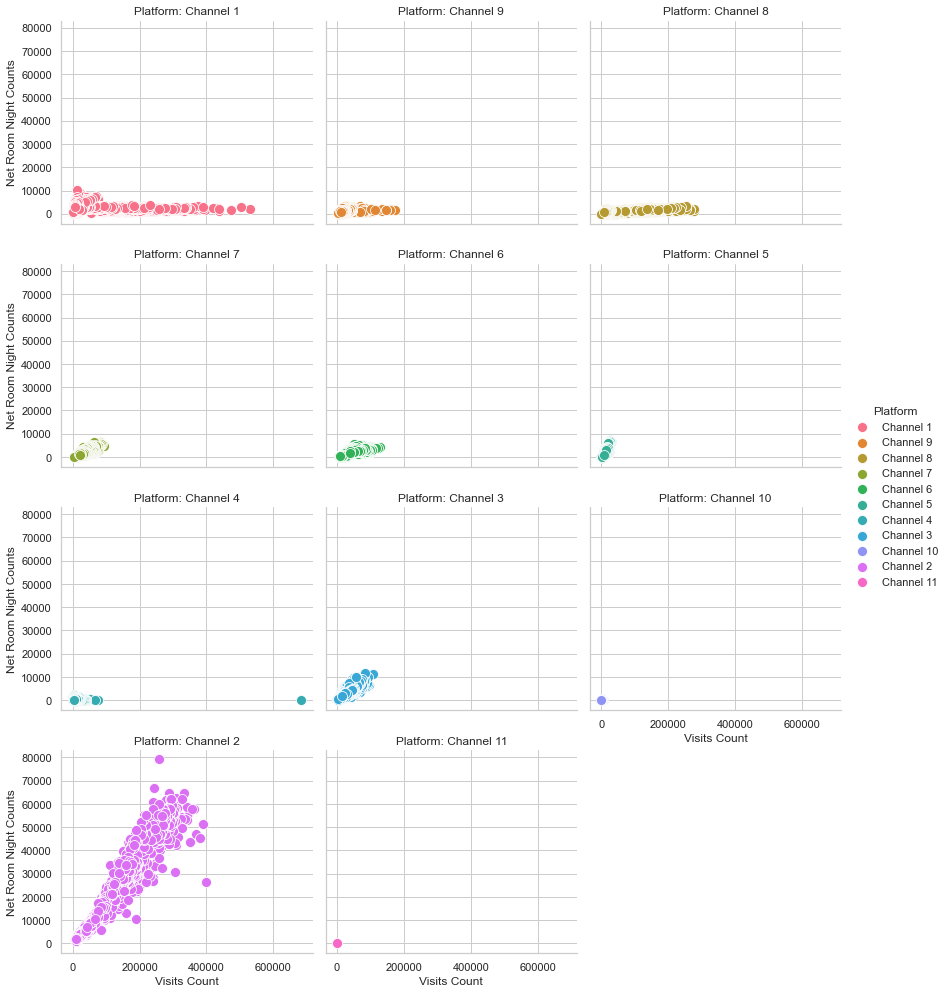

In [53]:
data = {
    "Visits Count": desktop["Visits"],
    "Net Room Night Counts": desktop["Net Room Nights"],
    "Platform": desktop["Marketing Channel"]
}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Set up Seaborn style (optional but recommended)
sns.set(style="whitegrid")

# Create separate scatter plots for each platform using facet_grid
g = sns.FacetGrid(df, col="Platform", hue="Platform", col_wrap=3, height=4)
g.map(sns.scatterplot, "Visits Count", "Net Room Night Counts", s=100)
g.set_axis_labels("Visits Count", "Net Room Night Counts")
g.set_titles("Platform: {col_name}")
g.add_legend(title="Platform")

# Adjust plot spacing
plt.subplots_adjust(top=0.85)  # Make room for the title

# Show the plots
plt.show()

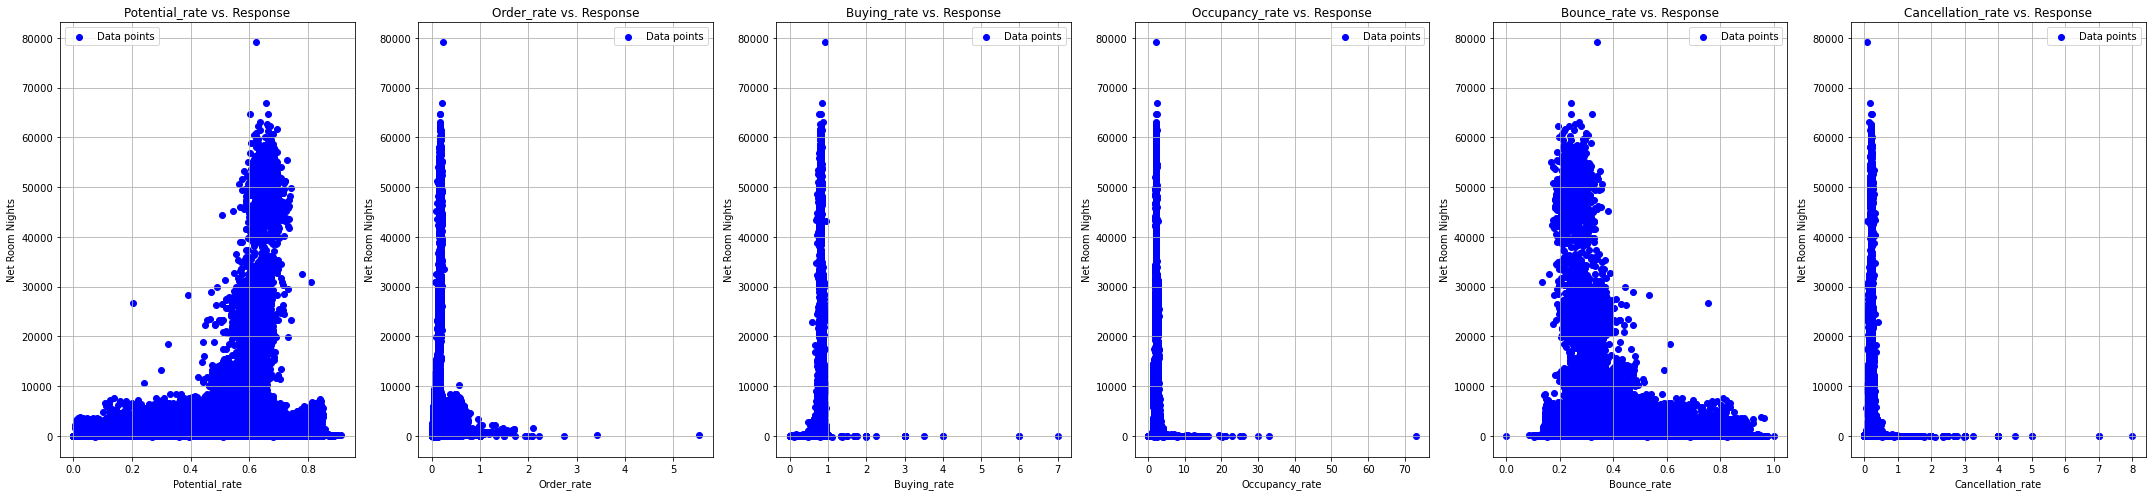

In [18]:
features = {
    'Potential_rate': up_dataset["Potential_rate"],
    'Order_rate': up_dataset["Order_rate"],
    'Buying_rate': up_dataset["Buying_rate"],
    'Occupancy_rate': up_dataset["Occupancy_rate"],
    'Bounce_rate': up_dataset["Bounce_rate"],
    'Cancellation_rate': up_dataset["Cancellation_rate"],
}

response = up_dataset["Net Room Nights"]

# Create a grid of multiple charts
fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(30, 7))

# Plot each feature-response relationship
for i, (feature_name, feature_values) in enumerate(features.items()):
    axes[i].scatter(feature_values, response, label='Data points', color='blue')
    axes[i].set_xlabel(feature_name)
    axes[i].set_ylabel('Net Room Nights')
    axes[i].set_title(f'{feature_name} vs. Response')
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.show()

**Conclusion:** The features Visits, Qualified Shoppers, Gross Orders, Net Orders seems to have a normal trend line. The Bounced Visits show an non-linear, exponential growth trend when plotted against response.

### **Dataset Preprocessing**

#### **Check Nulls  & Duplicated rows**

In [19]:
cols = up_dataset.columns
for i in range(0, len(cols)):
    count =  up_dataset[cols[i]].isnull().sum()
    print(cols[i]+ " count:",count)

up_dataset.duplicated().any()
duplicates = up_dataset[up_dataset.duplicated(keep=False)]
duplicates.head(2)

Date count: 0
Geographic Region count: 0
Platform count: 0
Marketing Channel count: 0
Visits count: 0
Qualified Shoppers count: 0
Bounced Visits count: 0
Gross Orders count: 0
Net Orders count: 0
Net Room Nights count: 0
Cancelled_Orders count: 0
Potential_rate count: 0
Order_rate count: 0
Buying_rate count: 0
Occupancy_rate count: 0
Bounce_rate count: 0
Cancellation_rate count: 0
Net_orders_QSV count: 0
Day count: 0
Month count: 0
Quarter count: 0
Year count: 0
Month_year count: 0
Day_of_week count: 0
Day_type count: 0
Week_number count: 0
Day_Number count: 0


,Date,Geographic Region,Platform,Marketing Channel,Visits,Qualified Shoppers,Bounced Visits,Gross Orders,Net Orders,Net Room Nights,Cancelled_Orders,Potential_rate,Order_rate,Buying_rate,Occupancy_rate,Bounce_rate,Cancellation_rate,Net_orders_QSV,Day,Month,Quarter,Year,Month_year,Day_of_week,Day_type,Week_number,Day_Number
6182,2017-03-17,Geo Region 2,Desktop,Channel 3,45182,23770,13415,2034,1767,4551,267,0.526,0.086,0.869,2.576,0.297,0.131,0.074,17,3,1,2017,03-2017,Friday,weekday,11,75
6183,2017-03-17,Geo Region 2,Desktop,Channel 4,21658,6393,14653,67,57,195,10,0.295,0.010,0.851,3.421,0.677,0.149,0.009,17,3,1,2017,03-2017,Friday,weekday,11,75


**Conclusion:**
* No nulls exist in any of the columns
* No Duplicates exist

#### **Anomoly Removals Analysis**

In [20]:
test = up_dataset[(up_dataset['Net Room Nights'] < 0)] 
print("Net Room Nights in Negatives:", test.shape)

print("Net Room Nights, Negatives values Impact:")
test.describe()

Net Room Nights in Negatives: (816, 27)
Net Room Nights, Negatives values Impact:


,Visits,Qualified Shoppers,Bounced Visits,Gross Orders,Net Orders,Net Room Nights,Cancelled_Orders,Potential_rate,Order_rate,Buying_rate,Occupancy_rate,Bounce_rate,Cancellation_rate,Net_orders_QSV,Day,Month,Quarter,Year,Week_number,Day_Number
count,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000
mean,1863.574755,433.971814,1280.859069,6.857843,0.512255,-8.208333,6.345588,0.269169,0.031801,0.362930,2.757018,0.652505,0.729847,0.114835,16.197304,6.386029,2.474265,2018.050245,25.882353,561.511029
std,2627.044834,615.749695,1914.202685,13.421049,8.042516,18.987842,13.798308,0.168300,0.087621,0.623141,4.380083,0.154077,0.859017,0.363574,9.566893,3.381182,1.089526,0.807131,14.816700,303.547936
min,1.000000,0.000000,0.000000,0.000000,-100.000000,-267.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2017.000000,1.000000,0.000000
25%,145.000000,35.750000,87.000000,0.000000,-1.000000,-8.000000,1.000000,0.137250,0.000000,0.000000,0.500000,0.548750,0.000000,0.002000,7.000000,4.000000,2.000000,2017.000000,14.000000,307.000000
50%,664.000000,121.500000,441.500000,2.000000,0.000000,-3.000000,2.000000,0.273500,0.010000,0.174500,1.600000,0.656500,0.571000,0.008000,17.000000,6.000000,2.000000,2018.000000,24.500000,560.000000
75%,2664.750000,601.000000,1690.500000,7.000000,2.000000,-2.000000,5.000000,0.383500,0.029250,0.500000,3.000000,0.767250,1.000000,0.032000,25.000000,9.000000,3.000000,2019.000000,38.000000,853.000000
max,16516.000000,5163.000000,12944.000000,104.000000,77.000000,-1.000000,174.000000,0.778000,1.000000,7.000000,73.000000,0.973000,8.000000,3.000000,31.000000,12.000000,4.000000,2019.000000,52.000000,1094.000000


In [21]:
print("Net Room Nights outliers removed:", test[test["Net Room Nights"] < -8 ].shape[0])
up_dataset = up_dataset[up_dataset["Net Room Nights"] > -8]

Net Room Nights outliers removed: 203


In [22]:
up_dataset.describe()

,Visits,Qualified Shoppers,Bounced Visits,Gross Orders,Net Orders,Net Room Nights,Cancelled_Orders,Potential_rate,Order_rate,Buying_rate,Occupancy_rate,Bounce_rate,Cancellation_rate,Net_orders_QSV,Day,Month,Quarter,Year,Week_number,Day_Number
count,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000
mean,27878.346260,12975.182902,12531.424392,1168.140055,942.568891,1999.593462,225.571164,0.483139,0.092277,0.788806,2.184322,0.444455,0.204563,0.074413,15.716200,6.521075,2.507185,2017.997818,26.454183,546.046959
std,42512.761461,21961.962913,23069.129696,3163.337391,2554.742079,5508.641719,620.998141,0.180211,0.112613,0.125124,0.675589,0.166581,0.117166,0.092547,8.786241,3.447769,1.117649,0.816948,15.046863,316.534125
min,1.000000,0.000000,0.000000,0.000000,-11.000000,-7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2017.000000,1.000000,0.000000
25%,4203.750000,1746.750000,1578.750000,75.000000,60.000000,131.000000,14.000000,0.374000,0.031000,0.753000,1.828000,0.319000,0.148000,0.024000,8.000000,4.000000,2.000000,2017.000000,13.000000,272.000000
50%,12366.000000,5837.000000,4949.000000,331.000000,263.000000,558.000000,58.000000,0.474000,0.052000,0.806000,2.134000,0.434000,0.193000,0.042000,16.000000,7.000000,3.000000,2018.000000,26.000000,546.000000
75%,33782.000000,15260.000000,13992.000000,1015.000000,810.000000,1666.000000,204.000000,0.619000,0.119000,0.851000,2.478000,0.531000,0.245000,0.094000,23.000000,10.000000,4.000000,2019.000000,39.000000,820.000000
max,683764.000000,280919.000000,546089.000000,38354.000000,35318.000000,79141.000000,9346.000000,0.913000,5.538000,3.000000,26.000000,1.000000,4.000000,4.154000,31.000000,12.000000,4.000000,2019.000000,52.000000,1094.000000


**Observation**: Considering the above table 25% percentile of the negative response data has extreme range of outlier values (Min to 25% comparison and Mean observation), hence we will be considering only values from -8 to + values for the dataset, removing 232 rows.

##### **Winsorization**

/Users/addltariq/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/addltariq/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/addltariq/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


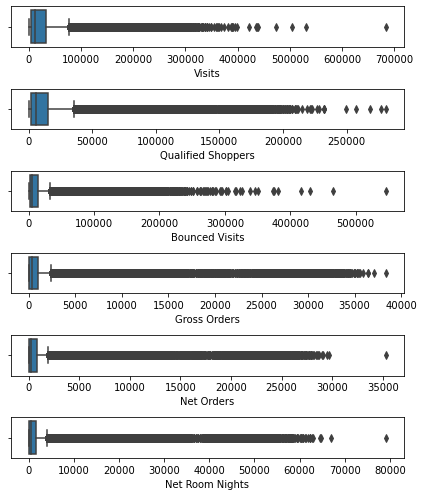

In [23]:
fig, axs = plt.subplots(6, figsize=(6,7))
plt1 = sns.boxplot(up_dataset['Visits'], ax=axs[0])
plt2 = sns.boxplot(up_dataset['Qualified Shoppers'], ax=axs[1])
plt3 = sns.boxplot(up_dataset['Bounced Visits'], ax=axs[2])
plt4 = sns.boxplot(up_dataset['Gross Orders'], ax=axs[3])
plt5 = sns.boxplot(up_dataset['Net Orders'], ax=axs[4])
plt6 = sns.boxplot(up_dataset['Net Room Nights'], ax=axs[5])

# Adjust the layout for better visualization
plt.tight_layout()

plt.show()  # Add this line to display the plots

In [24]:
test_1 = up_dataset.copy()
test_1["Visits"] = winsorize(up_dataset["Visits"], limits=(0, 0.01))
test_1["Qualified Shoppers"] = winsorize(up_dataset["Qualified Shoppers"], limits=(0, 0.01))
test_1["Bounced Visits"] = winsorize(up_dataset["Bounced Visits"], limits=(0, 0.01))
test_1["Gross Orders"] = winsorize(up_dataset["Gross Orders"], limits=(0, 0.01))
test_1["Net Orders"] = winsorize(up_dataset["Net Orders"], limits=(0, 0.01))
test_1["Net Room Nights"] = winsorize(up_dataset["Net Room Nights"], limits=(0, 0.01))

/Users/addltariq/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/addltariq/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/addltariq/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


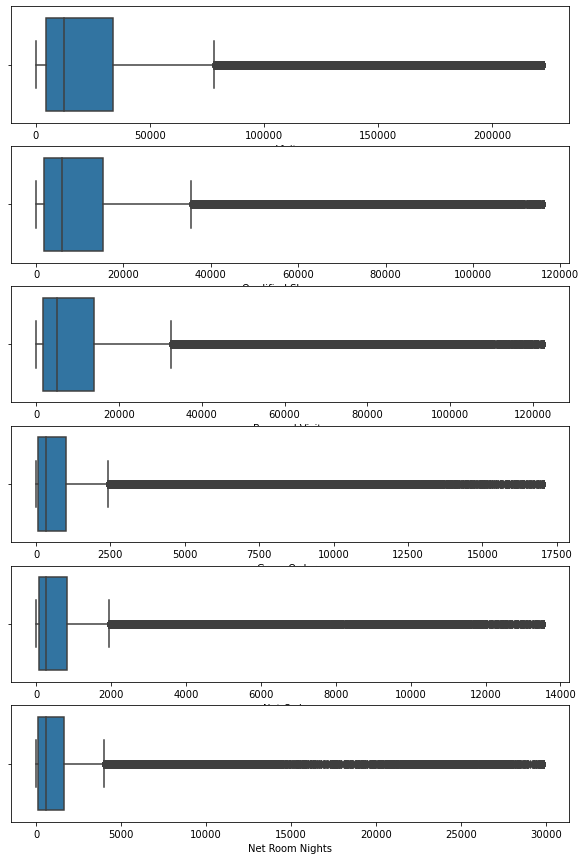

In [25]:
fig, axs = plt.subplots(6, figsize=(10,15))
plt1 = sns.boxplot(test_1['Visits'], ax=axs[0])
plt2 = sns.boxplot(test_1['Qualified Shoppers'], ax=axs[1])
plt3 = sns.boxplot(test_1['Bounced Visits'], ax=axs[2])
plt4 = sns.boxplot(test_1['Gross Orders'], ax=axs[3])
plt5 = sns.boxplot(test_1['Net Orders'], ax=axs[4])
plt6 = sns.boxplot(test_1['Net Room Nights'], ax=axs[5])

In [26]:
up_dataset.describe()

,Visits,Qualified Shoppers,Bounced Visits,Gross Orders,Net Orders,Net Room Nights,Cancelled_Orders,Potential_rate,Order_rate,Buying_rate,Occupancy_rate,Bounce_rate,Cancellation_rate,Net_orders_QSV,Day,Month,Quarter,Year,Week_number,Day_Number
count,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000
mean,27878.346260,12975.182902,12531.424392,1168.140055,942.568891,1999.593462,225.571164,0.483139,0.092277,0.788806,2.184322,0.444455,0.204563,0.074413,15.716200,6.521075,2.507185,2017.997818,26.454183,546.046959
std,42512.761461,21961.962913,23069.129696,3163.337391,2554.742079,5508.641719,620.998141,0.180211,0.112613,0.125124,0.675589,0.166581,0.117166,0.092547,8.786241,3.447769,1.117649,0.816948,15.046863,316.534125
min,1.000000,0.000000,0.000000,0.000000,-11.000000,-7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2017.000000,1.000000,0.000000
25%,4203.750000,1746.750000,1578.750000,75.000000,60.000000,131.000000,14.000000,0.374000,0.031000,0.753000,1.828000,0.319000,0.148000,0.024000,8.000000,4.000000,2.000000,2017.000000,13.000000,272.000000
50%,12366.000000,5837.000000,4949.000000,331.000000,263.000000,558.000000,58.000000,0.474000,0.052000,0.806000,2.134000,0.434000,0.193000,0.042000,16.000000,7.000000,3.000000,2018.000000,26.000000,546.000000
75%,33782.000000,15260.000000,13992.000000,1015.000000,810.000000,1666.000000,204.000000,0.619000,0.119000,0.851000,2.478000,0.531000,0.245000,0.094000,23.000000,10.000000,4.000000,2019.000000,39.000000,820.000000
max,683764.000000,280919.000000,546089.000000,38354.000000,35318.000000,79141.000000,9346.000000,0.913000,5.538000,3.000000,26.000000,1.000000,4.000000,4.154000,31.000000,12.000000,4.000000,2019.000000,52.000000,1094.000000


In [27]:
test_1.describe()

,Visits,Qualified Shoppers,Bounced Visits,Gross Orders,Net Orders,Net Room Nights,Cancelled_Orders,Potential_rate,Order_rate,Buying_rate,Occupancy_rate,Bounce_rate,Cancellation_rate,Net_orders_QSV,Day,Month,Quarter,Year,Week_number,Day_Number
count,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000
mean,27473.601263,12564.971854,12075.698871,1071.811900,865.023474,1841.426071,225.571164,0.483139,0.092277,0.788806,2.184322,0.444455,0.204563,0.074413,15.716200,6.521075,2.507185,2017.997818,26.454183,546.046959
std,40229.473746,19319.129061,19765.550450,2408.615997,1957.120497,4286.059983,620.998141,0.180211,0.112613,0.125124,0.675589,0.166581,0.117166,0.092547,8.786241,3.447769,1.117649,0.816948,15.046863,316.534125
min,1.000000,0.000000,0.000000,0.000000,-11.000000,-7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2017.000000,1.000000,0.000000
25%,4203.750000,1746.750000,1578.750000,75.000000,60.000000,131.000000,14.000000,0.374000,0.031000,0.753000,1.828000,0.319000,0.148000,0.024000,8.000000,4.000000,2.000000,2017.000000,13.000000,272.000000
50%,12366.000000,5837.000000,4949.000000,331.000000,263.000000,558.000000,58.000000,0.474000,0.052000,0.806000,2.134000,0.434000,0.193000,0.042000,16.000000,7.000000,3.000000,2018.000000,26.000000,546.000000
75%,33782.000000,15260.000000,13992.000000,1015.000000,810.000000,1666.000000,204.000000,0.619000,0.119000,0.851000,2.478000,0.531000,0.245000,0.094000,23.000000,10.000000,4.000000,2019.000000,39.000000,820.000000
max,222485.000000,116135.000000,122482.000000,17048.000000,13545.000000,29841.000000,9346.000000,0.913000,5.538000,3.000000,26.000000,1.000000,4.000000,4.154000,31.000000,12.000000,4.000000,2019.000000,52.000000,1094.000000


**Conclusion:** Some of the response values are in Negatives which will cause a problem when applying regression models, hence we need since need to remove such values from the dataset. Winzorisation remove some of the anamolies from the top end of the features.

In [28]:
data = test_1.copy()

#### **Check Reponse Trend**

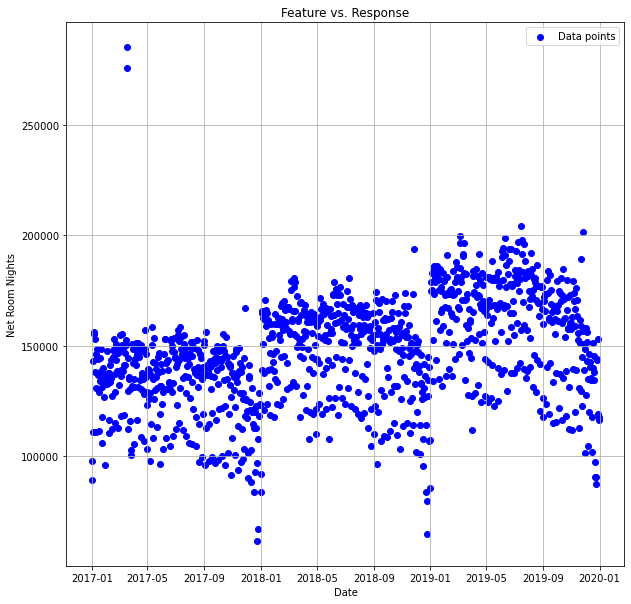

In [29]:
# Convert the 'Date' column to datetime type
data['Date'] = pd.to_datetime(dataset['Date'])
grouped = data.groupby('Date')['Net Room Nights'].sum()
# Rename the 'Value' column as 'Response'
grouped = grouped.reset_index(name='Response')

feature = grouped['Date']
response = grouped["Response"]

# Create a scatter plot
plt.figure(figsize=(10, 10)) 
plt.scatter(feature, response, label='Data points', color='blue')
plt.xlabel('Date')
plt.ylabel('Net Room Nights')
plt.title('Feature vs. Response')
plt.legend()
plt.grid(True)
plt.show()

**Conclusion:** The response (Net Romm Nights) seems to have seasonality and trend.

#### **Check Normal Distibution of Response**

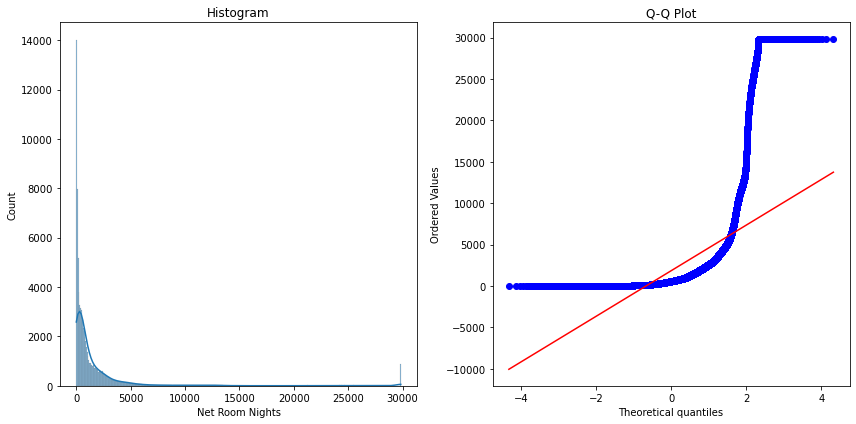

In [30]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data["Net Room Nights"], kde=True)
plt.title('Histogram')

plt.subplot(1, 2, 2)
stats.probplot(data["Net Room Nights"], dist="norm", plot=plt)
plt.title('Q-Q Plot')

plt.tight_layout()
plt.show()

**Observation**: The response variable ("Net Room Nights") is not normally distributed and is skewed (Long tail distribution - Skewness), Hence we will have to Log transform the Response to mitigate this issue.

In [32]:
transformed_dataset = data.copy()
#Implementation of Log Transformation
 # Adjust the constant as needed based on the minimum value to prevent issue in Log transformation of negative values
constant_to_add = 12 

# Add the constant to make all values positive for the Response
positive_response = data["Net Room Nights"] + constant_to_add
transformed_dataset["Net Room Nights"] = np.log(positive_response)

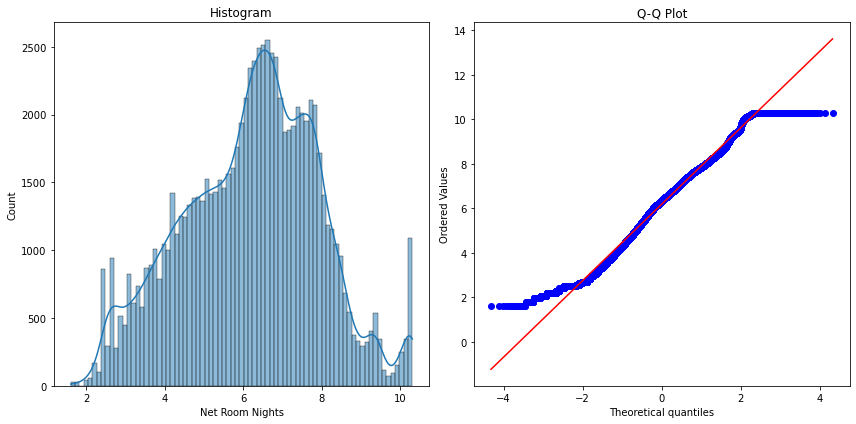

In [33]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(transformed_dataset["Net Room Nights"] , kde=True)
plt.title('Histogram')

plt.subplot(1, 2, 2)
stats.probplot(transformed_dataset["Net Room Nights"] , dist="norm", plot=plt)
plt.title('Q-Q Plot')

plt.tight_layout()
plt.show()

In [34]:
transformed_dataset.describe()

,Visits,Qualified Shoppers,Bounced Visits,Gross Orders,Net Orders,Net Room Nights,Cancelled_Orders,Potential_rate,Order_rate,Buying_rate,Occupancy_rate,Bounce_rate,Cancellation_rate,Net_orders_QSV,Day,Month,Quarter,Year,Week_number,Day_Number
count,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000
mean,27473.601263,12564.971854,12075.698871,1071.811900,865.023474,6.190030,225.571164,0.483139,0.092277,0.788806,2.184322,0.444455,0.204563,0.074413,15.716200,6.521075,2.507185,2017.997818,26.454183,546.046959
std,40229.473746,19319.129061,19765.550450,2408.615997,1957.120497,1.728916,620.998141,0.180211,0.112613,0.125124,0.675589,0.166581,0.117166,0.092547,8.786241,3.447769,1.117649,0.816948,15.046863,316.534125
min,1.000000,0.000000,0.000000,0.000000,-11.000000,1.609438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2017.000000,1.000000,0.000000
25%,4203.750000,1746.750000,1578.750000,75.000000,60.000000,4.962845,14.000000,0.374000,0.031000,0.753000,1.828000,0.319000,0.148000,0.024000,8.000000,4.000000,2.000000,2017.000000,13.000000,272.000000
50%,12366.000000,5837.000000,4949.000000,331.000000,263.000000,6.345636,58.000000,0.474000,0.052000,0.806000,2.134000,0.434000,0.193000,0.042000,16.000000,7.000000,3.000000,2018.000000,26.000000,546.000000
75%,33782.000000,15260.000000,13992.000000,1015.000000,810.000000,7.425358,204.000000,0.619000,0.119000,0.851000,2.478000,0.531000,0.245000,0.094000,23.000000,10.000000,4.000000,2019.000000,39.000000,820.000000
max,222485.000000,116135.000000,122482.000000,17048.000000,13545.000000,10.304041,9346.000000,0.913000,5.538000,3.000000,26.000000,1.000000,4.000000,4.154000,31.000000,12.000000,4.000000,2019.000000,52.000000,1094.000000


In [35]:
data.describe()

,Visits,Qualified Shoppers,Bounced Visits,Gross Orders,Net Orders,Net Room Nights,Cancelled_Orders,Potential_rate,Order_rate,Buying_rate,Occupancy_rate,Bounce_rate,Cancellation_rate,Net_orders_QSV,Day,Month,Quarter,Year,Week_number,Day_Number
count,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000
mean,27473.601263,12564.971854,12075.698871,1071.811900,865.023474,1841.426071,225.571164,0.483139,0.092277,0.788806,2.184322,0.444455,0.204563,0.074413,15.716200,6.521075,2.507185,2017.997818,26.454183,546.046959
std,40229.473746,19319.129061,19765.550450,2408.615997,1957.120497,4286.059983,620.998141,0.180211,0.112613,0.125124,0.675589,0.166581,0.117166,0.092547,8.786241,3.447769,1.117649,0.816948,15.046863,316.534125
min,1.000000,0.000000,0.000000,0.000000,-11.000000,-7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2017.000000,1.000000,0.000000
25%,4203.750000,1746.750000,1578.750000,75.000000,60.000000,131.000000,14.000000,0.374000,0.031000,0.753000,1.828000,0.319000,0.148000,0.024000,8.000000,4.000000,2.000000,2017.000000,13.000000,272.000000
50%,12366.000000,5837.000000,4949.000000,331.000000,263.000000,558.000000,58.000000,0.474000,0.052000,0.806000,2.134000,0.434000,0.193000,0.042000,16.000000,7.000000,3.000000,2018.000000,26.000000,546.000000
75%,33782.000000,15260.000000,13992.000000,1015.000000,810.000000,1666.000000,204.000000,0.619000,0.119000,0.851000,2.478000,0.531000,0.245000,0.094000,23.000000,10.000000,4.000000,2019.000000,39.000000,820.000000
max,222485.000000,116135.000000,122482.000000,17048.000000,13545.000000,29841.000000,9346.000000,0.913000,5.538000,3.000000,26.000000,1.000000,4.000000,4.154000,31.000000,12.000000,4.000000,2019.000000,52.000000,1094.000000


**Conclusion**: The response variable ("Net Room Nights") is  normally distributed after the log transformation.

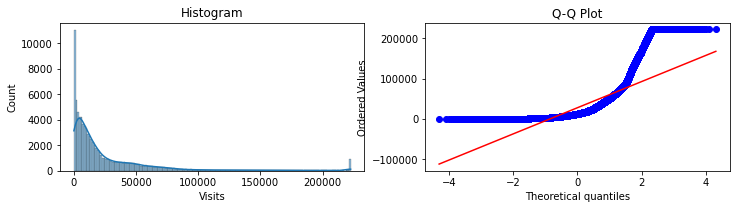

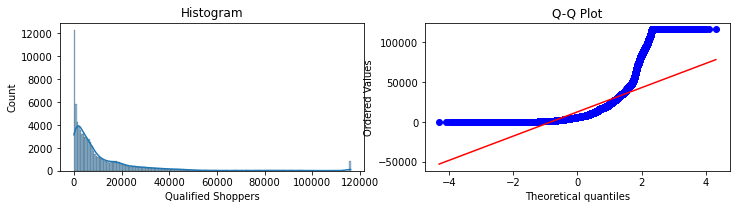

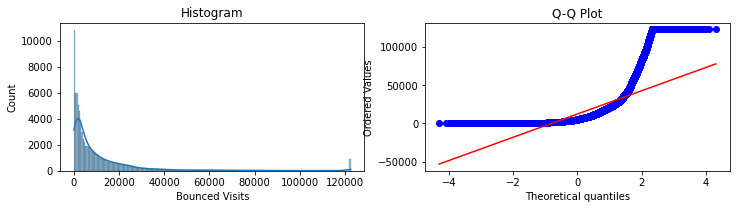

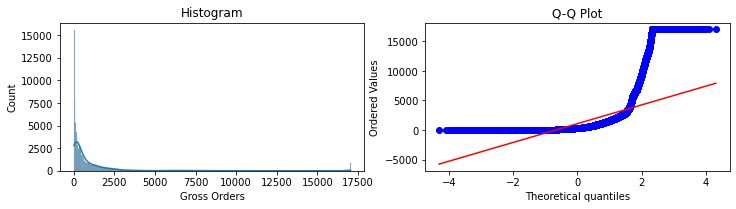

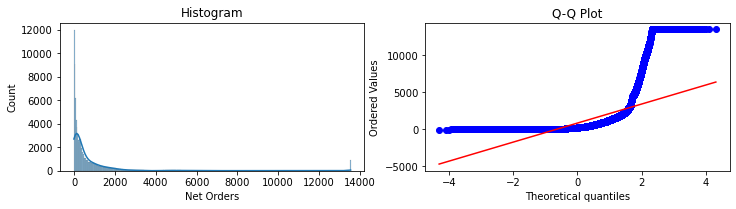

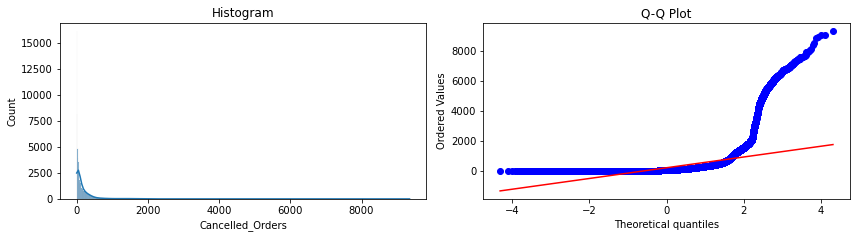

In [36]:
features = {
    'Visits': data["Visits"],
    'Qualified Shoppers': data["Qualified Shoppers"],
    'Bounced Visits': data["Bounced Visits"],
    'Gross Orders': data["Gross Orders"],
    'Net Orders': data["Net Orders"],
    'Cancelled_Orders': data["Cancelled_Orders"]

}

for i, (feature_name, feature_values) in enumerate(features.items()):
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 2, 1)
    sns.histplot(feature_values, kde=True)
    plt.title('Histogram')

    plt.subplot(2, 2, 2)
    stats.probplot(feature_values, dist="norm", plot=plt)
    plt.title('Q-Q Plot')

plt.tight_layout()
plt.show()

**Observation**: The predictors are skewed to the left (Long tail distribution - Skewness), Hence we will have to Log transform to normalise the distribution.

In [37]:
#Implementation of Log Transformation for numerical features
constant_to_add = 12 

# Add the constant to make all values positive for the Visits
transformed_dataset["Visits"]  =  data["Visits"] + constant_to_add
transformed_dataset["Visits"] = np.log(transformed_dataset["Visits"])

# Add the constant to make all values positive for the QSV
transformed_dataset["Qualified Shoppers"]  =  data["Qualified Shoppers"] + constant_to_add
transformed_dataset["Qualified Shoppers"] = np.log(transformed_dataset["Qualified Shoppers"])

# Add the constant to make all values positive for the Gross Orders
transformed_dataset["Gross Orders"]  =  data["Gross Orders"] + constant_to_add
transformed_dataset["Gross Orders"] = np.log(transformed_dataset["Gross Orders"])

# Add the constant to make all values positive for the Bounced Visits
transformed_dataset["Bounced Visits"]  =  data["Bounced Visits"] + constant_to_add
transformed_dataset["Bounced Visits"] = np.log(transformed_dataset["Bounced Visits"])

# Add the constant to make all values positive for the Net Orders
transformed_dataset["Net Orders"]  =  data["Net Orders"] + constant_to_add
transformed_dataset["Net Orders"] = np.log(transformed_dataset["Net Orders"])

# Add the constant to make all values positive for the Cancelled_Orders
transformed_dataset["Cancelled_Orders"]  =  data["Cancelled_Orders"] + constant_to_add
transformed_dataset["Cancelled_Orders"] = np.log(transformed_dataset["Cancelled_Orders"])

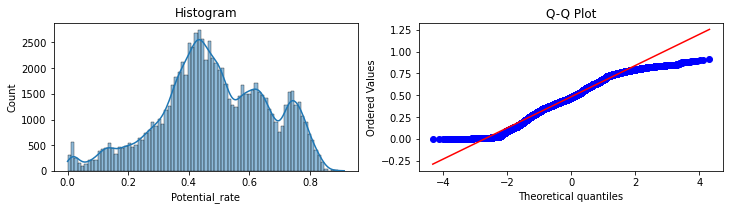

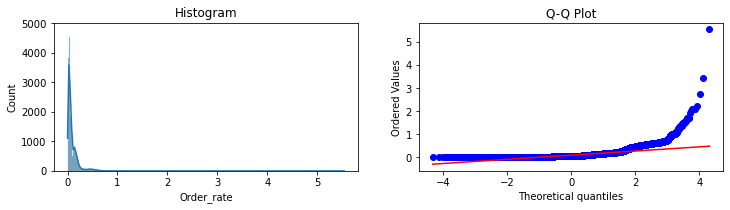

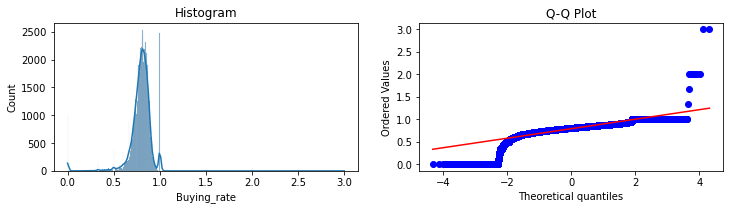

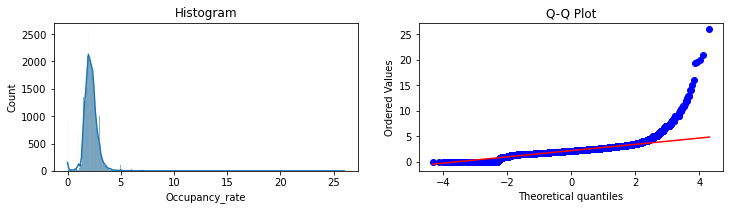

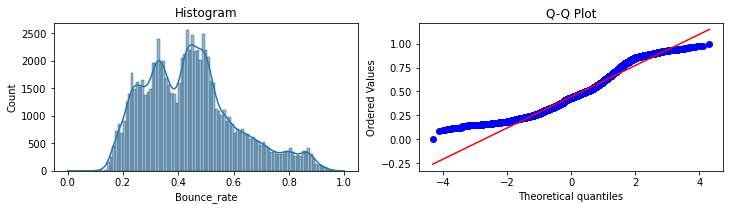

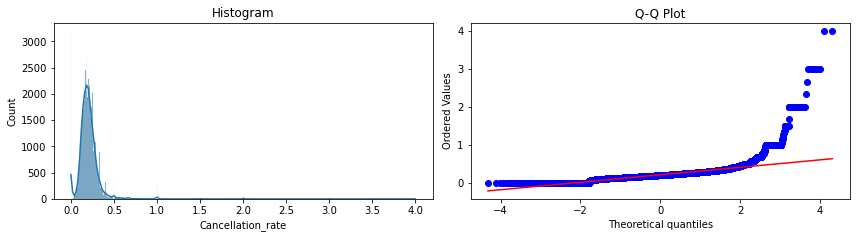

In [38]:
features = {
    'Potential_rate': transformed_dataset["Potential_rate"],
    'Order_rate': transformed_dataset["Order_rate"],
    'Buying_rate': transformed_dataset["Buying_rate"],
    'Occupancy_rate': transformed_dataset["Occupancy_rate"],
    'Bounce_rate': transformed_dataset["Bounce_rate"],
    'Cancellation_rate': transformed_dataset["Cancellation_rate"]
}


for i, (feature_name, feature_values) in enumerate(features.items()):
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 2, 1)
    sns.histplot(feature_values, kde=True)
    plt.title('Histogram')

    plt.subplot(2, 2, 2)
    stats.probplot(feature_values, dist="norm", plot=plt)
    plt.title('Q-Q Plot')

plt.tight_layout()
plt.show()

In [39]:
data.describe()

,Visits,Qualified Shoppers,Bounced Visits,Gross Orders,Net Orders,Net Room Nights,Cancelled_Orders,Potential_rate,Order_rate,Buying_rate,Occupancy_rate,Bounce_rate,Cancellation_rate,Net_orders_QSV,Day,Month,Quarter,Year,Week_number,Day_Number
count,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000,87544.000000
mean,27473.601263,12564.971854,12075.698871,1071.811900,865.023474,1841.426071,225.571164,0.483139,0.092277,0.788806,2.184322,0.444455,0.204563,0.074413,15.716200,6.521075,2.507185,2017.997818,26.454183,546.046959
std,40229.473746,19319.129061,19765.550450,2408.615997,1957.120497,4286.059983,620.998141,0.180211,0.112613,0.125124,0.675589,0.166581,0.117166,0.092547,8.786241,3.447769,1.117649,0.816948,15.046863,316.534125
min,1.000000,0.000000,0.000000,0.000000,-11.000000,-7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2017.000000,1.000000,0.000000
25%,4203.750000,1746.750000,1578.750000,75.000000,60.000000,131.000000,14.000000,0.374000,0.031000,0.753000,1.828000,0.319000,0.148000,0.024000,8.000000,4.000000,2.000000,2017.000000,13.000000,272.000000
50%,12366.000000,5837.000000,4949.000000,331.000000,263.000000,558.000000,58.000000,0.474000,0.052000,0.806000,2.134000,0.434000,0.193000,0.042000,16.000000,7.000000,3.000000,2018.000000,26.000000,546.000000
75%,33782.000000,15260.000000,13992.000000,1015.000000,810.000000,1666.000000,204.000000,0.619000,0.119000,0.851000,2.478000,0.531000,0.245000,0.094000,23.000000,10.000000,4.000000,2019.000000,39.000000,820.000000
max,222485.000000,116135.000000,122482.000000,17048.000000,13545.000000,29841.000000,9346.000000,0.913000,5.538000,3.000000,26.000000,1.000000,4.000000,4.154000,31.000000,12.000000,4.000000,2019.000000,52.000000,1094.000000


In [40]:
transformed_dataset = transformed_dataset[transformed_dataset["Order_rate"] <= 1]
transformed_dataset = transformed_dataset[transformed_dataset["Buying_rate"] <= 1]
transformed_dataset = transformed_dataset[transformed_dataset["Occupancy_rate"] <= 5]
transformed_dataset = transformed_dataset[transformed_dataset["Cancellation_rate"] <= 1]

In [41]:
transformed_dataset.describe()

,Visits,Qualified Shoppers,Bounced Visits,Gross Orders,Net Orders,Net Room Nights,Cancelled_Orders,Potential_rate,Order_rate,Buying_rate,Occupancy_rate,Bounce_rate,Cancellation_rate,Net_orders_QSV,Day,Month,Quarter,Year,Week_number,Day_Number
count,87060.000000,87060.000000,87060.000000,87060.000000,87060.000000,87060.000000,87060.000000,87060.000000,87060.000000,87060.000000,87060.000000,87060.000000,87060.000000,87060.000000,87060.000000,87060.000000,87060.000000,87060.000000,87060.000000,87060.000000
mean,9.246927,8.421385,8.367721,5.735855,5.536092,6.204427,4.414409,0.484181,0.091577,0.789120,2.165595,0.443379,0.202277,0.073877,15.716265,6.520652,2.506880,2017.998174,26.451367,546.163944
std,1.630555,1.692031,1.624078,1.635822,1.609232,1.720282,1.330626,0.179800,0.105153,0.122662,0.581846,0.166072,0.099986,0.086924,8.784118,3.447929,1.117721,0.817027,15.047373,316.532140
min,2.564949,2.484907,2.484907,2.484907,2.197225,1.609438,2.484907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2017.000000,1.000000,0.000000
25%,8.369853,7.502738,7.383213,4.488636,4.290459,4.983607,3.258097,0.375000,0.031000,0.754000,1.826000,0.318000,0.148000,0.024000,8.000000,4.000000,2.000000,2017.000000,13.000000,272.000000
50%,9.432283,8.682284,8.521584,5.846439,5.627621,6.352629,4.262680,0.475000,0.052000,0.806000,2.132000,0.433000,0.193000,0.042000,16.000000,7.000000,3.000000,2018.000000,26.000000,546.000000
75%,10.433903,9.640173,9.552954,6.942157,6.717805,7.431892,5.379897,0.620000,0.119000,0.851000,2.474000,0.530000,0.244000,0.094000,23.000000,10.000000,4.000000,2019.000000,39.000000,820.000000
max,12.312669,11.662612,11.715817,9.744492,9.514658,10.304041,9.143987,0.913000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,31.000000,12.000000,4.000000,2019.000000,52.000000,1094.000000


#### **Encoding Columns**

We are required to encode the categorical columns
* Geographic Region
* Marketing Channel
* Platform

In [42]:
df_eng = transformed_dataset.copy()

##### **One Hot Encoding:**

In [43]:

# passing categorical columns (label encoded values of categorical columns)
gr_df = pd.get_dummies(df_eng[["Geographic Region"]], columns=["Geographic Region"], prefix=[""] )
mc_df = pd.get_dummies(df_eng[["Marketing Channel"]], columns=["Marketing Channel"], prefix=[""])
dt_df = pd.get_dummies(df_eng[["Day_type"]], columns=["Day_type"], prefix=[""])
my_df = pd.get_dummies(df_eng[["Month_year"]], columns=["Month_year"], prefix=[""])
p_df = pd.get_dummies(df_eng[["Platform"]], columns=["Platform"], prefix=[""] )


# merge with main dataset on key values
df_eng = df_eng.join(gr_df)
df_eng = df_eng.join(mc_df)
df_eng = df_eng.join(dt_df)
df_eng = df_eng.join(my_df)
df_eng = df_eng.join(p_df)

##### **Label Encoding:**

In [44]:
# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
# df_eng['Geographic Region_lb'] = labelencoder.fit_transform(df_eng['Geographic Region'])
# df_eng['Marketing Channel_lb'] = labelencoder.fit_transform(df_eng['Marketing Channel'])
#df_eng['Platform_lb'] = labelencoder.fit_transform(df_eng['Platform'])
df_eng['Day_of_week_lb'] = labelencoder.fit_transform(df_eng['Day_of_week'])


In [45]:
print("Shape of the Dataset: ", df_eng.shape)
df_eng.head(3)

Shape of the Dataset:  (87060, 83)


,Date,Geographic Region,Platform,Marketing Channel,Visits,Qualified Shoppers,Bounced Visits,Gross Orders,Net Orders,Net Room Nights,Cancelled_Orders,Potential_rate,Order_rate,Buying_rate,Occupancy_rate,Bounce_rate,Cancellation_rate,Net_orders_QSV,Day,Month,Quarter,Year,Month_year,Day_of_week,Day_type,Week_number,Day_Number,_Geo Region 1,_Geo Region 2,_Geo Region 3,_Geo Region 4,_Channel 1,_Channel 10,_Channel 11,_Channel 2,_Channel 3,_Channel 4,_Channel 5,_Channel 6,_Channel 7,_Channel 8,_Channel 9,_weekday,_weekend,_01-2017,_01-2018,_01-2019,_02-2017,_02-2018,_02-2019,_03-2017,_03-2018,_03-2019,_04-2017,_04-2018,_04-2019,_05-2017,_05-2018,_05-2019,_06-2017,_06-2018,_06-2019,_07-2017,_07-2018,_07-2019,_08-2017,_08-2018,_08-2019,_09-2017,_09-2018,_09-2019,_10-2017,_10-2018,_10-2019,_11-2017,_11-2018,_11-2019,_12-2017,_12-2018,_12-2019,_Desktop,_Mobile,Day_of_week_lb
0,2017-01-01,Geo Region 1,Desktop,Channel 1,8.014005,7.544332,6.712956,7.048386,6.876265,7.528332,5.267858,0.624,0.606,0.840,1.931,0.269,0.160,0.510,1,1,1,2017,01-2017,Sunday,weekend,52,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3
57,2017-01-01,Geo Region 3,Mobile,Channel 8,8.884056,8.259717,8.119696,5.579730,5.420535,6.093570,3.931826,0.535,0.066,0.846,2.014,0.465,0.154,0.056,1,1,1,2017,01-2017,Sunday,weekend,52,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
56,2017-01-01,Geo Region 3,Mobile,Channel 7,10.057110,9.397732,9.162934,5.700444,5.541264,6.098074,4.025352,0.517,0.024,0.847,1.782,0.409,0.153,0.020,1,1,1,2017,01-2017,Sunday,weekend,52,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3


* Drop one column from each category when ONE Hot encoding*

### **Feature Selection**

#### **SelectKBest for Feature Selection Test**

We will be required to drop the categorical columns from the dataset to test Feature Significance.

In [46]:
df_eng.columns

Index(['Date', 'Geographic Region', 'Platform', 'Marketing Channel', 'Visits',
       'Qualified Shoppers', 'Bounced Visits', 'Gross Orders', 'Net Orders',
       'Net Room Nights', 'Cancelled_Orders', 'Potential_rate', 'Order_rate',
       'Buying_rate', 'Occupancy_rate', 'Bounce_rate', 'Cancellation_rate',
       'Net_orders_QSV', 'Day', 'Month', 'Quarter', 'Year', 'Month_year',
       'Day_of_week', 'Day_type', 'Week_number', 'Day_Number', '_Geo Region 1',
       '_Geo Region 2', '_Geo Region 3', '_Geo Region 4', '_Channel 1',
       '_Channel 10', '_Channel 11', '_Channel 2', '_Channel 3', '_Channel 4',
       '_Channel 5', '_Channel 6', '_Channel 7', '_Channel 8', '_Channel 9',
       '_weekday', '_weekend', '_01-2017', '_01-2018', '_01-2019', '_02-2017',
       '_02-2018', '_02-2019', '_03-2017', '_03-2018', '_03-2019', '_04-2017',
       '_04-2018', '_04-2019', '_05-2017', '_05-2018', '_05-2019', '_06-2017',
       '_06-2018', '_06-2019', '_07-2017', '_07-2018', '_07-2019', '_08

In [47]:

X =  df_eng[[ 'Visits', 'Qualified Shoppers', 'Bounced Visits', 'Gross Orders', 'Net Orders', 'Cancelled_Orders','Potential_rate', 'Order_rate',
       'Buying_rate', 'Occupancy_rate', 'Bounce_rate', 'Cancellation_rate',
       'Net_orders_QSV', 'Day', 'Month', 'Quarter', 'Year', 'Week_number', 'Day_Number', '_Geo Region 1',
       '_Geo Region 2', '_Geo Region 3', '_Channel 1',
       '_Channel 10', '_Channel 2', '_Channel 3', '_Channel 4',
       '_Channel 5', '_Channel 6', '_Channel 7', '_Channel 8', '_Channel 9',
       '_weekday' , '_01-2018', '_01-2019', '_02-2017',
       '_02-2018', '_02-2019', '_03-2017', '_03-2018', '_03-2019', '_04-2017',
       '_04-2018', '_04-2019', '_05-2017', '_05-2018', '_05-2019', '_06-2017',
       '_06-2018', '_06-2019', '_07-2017', '_07-2018', '_07-2019', '_08-2017',
       '_08-2018', '_08-2019', '_09-2017', '_09-2018', '_09-2019', '_10-2017',
       '_10-2018', '_10-2019', '_11-2017', '_11-2018', '_11-2019', '_12-2017',
       '_12-2018', '_12-2019', '_Desktop', 'Day_of_week_lb']]
y = df_eng['Net Room Nights']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 100)

# Applying SelectKBest class to extract top 25 best features
fs = SelectKBest(score_func=f_regression, k=25)
# Applying feature selection
fit = fs.fit(X,y)

features_score = pd.DataFrame(fit.scores_)
features = pd.DataFrame(X.columns)
feature_score = pd.concat([features,features_score],axis=1)

# Assigning column names
feature_score.columns = ["Input_Features","F_Score"]
print(feature_score.nlargest(25,columns="F_Score"))

        Input_Features       F_Score
4           Net Orders  4.462822e+06
3         Gross Orders  4.105432e+06
5     Cancelled_Orders  7.185662e+05
1   Qualified Shoppers  2.031148e+05
0               Visits  1.500855e+05
2       Bounced Visits  8.599672e+04
24          _Channel 2  2.185878e+04
23         _Channel 10  1.969018e+04
10         Bounce_rate  1.502657e+04
26          _Channel 4  1.487158e+04
7           Order_rate  1.165526e+04
68            _Desktop  1.099538e+04
12      Net_orders_QSV  1.055739e+04
19       _Geo Region 1  8.805349e+03
6       Potential_rate  8.206127e+03
8          Buying_rate  5.027241e+03
25          _Channel 3  2.095721e+03
20       _Geo Region 2  1.752984e+03
22          _Channel 1  1.284845e+03
29          _Channel 7  1.038320e+03
16                Year  9.406883e+02
18          Day_Number  8.327783e+02
11   Cancellation_rate  8.318698e+02
9       Occupancy_rate  5.457720e+02
28          _Channel 6  3.635780e+02


**Conclusion:** Some of the input features show a high correlation with response, although the SelectKBest feature selection test doesnt elaborate on the mult-colinearity between the assumed independent variables. 
Therefore, we will have to create a co-relation chart to analysis the relationship b/w the feature set. We select the **top 17 Input Features** from the SelectKBest test for the correlation chart.

#### **Correlation Chart**

The following columns have minimal correlation to the Target variable (Net Room Nights) in our first case:
* Day
* Month
* Quarter
* Time
* Year
* Net Nights per Orders
* QSV per Net Orders
* Label encoded Categorical columns (Channels, Platform, Geo Regions)

Some Independent considered columns are highly correlated (Hence we need remove the following columns):
* Gross Orders
* Cancelled Orders


In [48]:
df_prep = df_eng.copy()

# Selecting features

df_prep = df_prep[["Net Room Nights",'Visits', 'Qualified Shoppers', 'Bounced Visits', 'Gross Orders', 'Net Orders', 'Cancelled_Orders',"_Channel 2","_Channel 10","Bounce_rate","_Channel 4","Order_rate","_Desktop","Net_orders_QSV","_Geo Region 1","Potential_rate","Buying_rate","_Channel 3"]]

corr = df_prep.corr()
corr

,Net Room Nights,Visits,Qualified Shoppers,Bounced Visits,Gross Orders,Net Orders,Cancelled_Orders,_Channel 2,_Channel 10,Bounce_rate,_Channel 4,Order_rate,_Desktop,Net_orders_QSV,_Geo Region 1,Potential_rate,Buying_rate,_Channel 3
Net Room Nights,1.000000,0.795543,0.836647,0.704935,0.989563,0.990387,0.944424,0.447987,-0.429482,-0.383663,-0.381969,0.343616,0.334868,0.328866,0.303073,0.293498,0.233652,0.153319
Visits,0.795543,1.000000,0.944528,0.972818,0.806557,0.799815,0.770547,0.370147,-0.567105,-0.097124,-0.187528,-0.065276,0.070634,-0.086100,0.191740,0.027192,0.115010,0.145053
Qualified Shoppers,0.836647,0.944528,1.000000,0.860804,0.846391,0.841395,0.794011,0.390373,-0.570992,-0.370508,-0.291737,-0.109009,0.057968,-0.122851,0.213180,0.317188,0.194367,0.135054
Bounced Visits,0.704935,0.972818,0.860804,1.000000,0.714603,0.707882,0.685891,0.344656,-0.510320,0.127766,-0.100474,-0.069355,0.049033,-0.089411,0.157427,-0.186565,0.079852,0.117034
Gross Orders,0.989563,0.806557,0.846391,0.714603,1.000000,0.998495,0.970155,0.453093,-0.434659,-0.388580,-0.366387,0.332534,0.279116,0.315356,0.360381,0.293206,0.176266,0.154468
Net Orders,0.990387,0.799815,0.841395,0.707882,0.998495,1.000000,0.962682,0.462047,-0.426004,-0.389468,-0.373143,0.334990,0.270792,0.321544,0.357085,0.297145,0.206100,0.146559
Cancelled_Orders,0.944424,0.770547,0.794011,0.685891,0.970155,0.962682,1.000000,0.468236,-0.395454,-0.353598,-0.306521,0.329670,0.314387,0.302020,0.389007,0.244045,0.036945,0.165756
_Channel 2,0.447987,0.370147,0.390373,0.344656,0.453093,0.462047,0.468236,1.000000,-0.110943,-0.132583,-0.108808,0.028071,0.000169,0.031221,-0.000648,0.101661,0.096451,-0.112098
_Channel 10,-0.429482,-0.567105,-0.570992,-0.510320,-0.434659,-0.426004,-0.395454,-0.110943,1.000000,0.205153,-0.107681,0.069249,-0.001487,0.075043,0.002975,-0.180204,0.021315,-0.110936
Bounce_rate,-0.383663,-0.097124,-0.370508,0.127766,-0.388580,-0.389468,-0.353598,-0.132583,0.205153,1.000000,0.404106,0.007758,-0.044497,0.008019,-0.115098,-0.930976,-0.182285,-0.152110


#### **Check Multicollinearity**

We will utilize the Variance Inflation Factor (VIF) to verify if there is multicollinearity b/w independent variables.
The larger the value of R-squared, larger VIF can be b/w features. VIF above 5 is considered highly correlated.

In [49]:
X = df_prep[["_Channel 2","_Channel 10","Bounce_rate","_Channel 4","Order_rate","_Desktop","_Geo Region 1","Potential_rate","_Channel 3"]]


vif_data = pd.DataFrame()

# using the filtered  columns based on ANOVA TEST and Correlation chart analysis
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

          feature       VIF
0      _Channel 2  1.159019
1     _Channel 10  1.247471
2     Bounce_rate  4.024907
3      _Channel 4  1.451322
4      Order_rate  2.195553
5        _Desktop  2.325070
6   _Geo Region 1  1.466560
7  Potential_rate  3.365581
8      _Channel 3  1.124258


### **Model Implementation**

We will be applying Multi-linear Regression model to review best selected features.

In [50]:
df_eng

,Date,Geographic Region,Platform,Marketing Channel,Visits,Qualified Shoppers,Bounced Visits,Gross Orders,Net Orders,Net Room Nights,Cancelled_Orders,Potential_rate,Order_rate,Buying_rate,Occupancy_rate,Bounce_rate,Cancellation_rate,Net_orders_QSV,Day,Month,Quarter,Year,Month_year,Day_of_week,Day_type,Week_number,Day_Number,_Geo Region 1,_Geo Region 2,_Geo Region 3,_Geo Region 4,_Channel 1,_Channel 10,_Channel 11,_Channel 2,_Channel 3,_Channel 4,_Channel 5,_Channel 6,_Channel 7,_Channel 8,_Channel 9,_weekday,_weekend,_01-2017,_01-2018,_01-2019,_02-2017,_02-2018,_02-2019,_03-2017,_03-2018,_03-2019,_04-2017,_04-2018,_04-2019,_05-2017,_05-2018,_05-2019,_06-2017,_06-2018,_06-2019,_07-2017,_07-2018,_07-2019,_08-2017,_08-2018,_08-2019,_09-2017,_09-2018,_09-2019,_10-2017,_10-2018,_10-2019,_11-2017,_11-2018,_11-2019,_12-2017,_12-2018,_12-2019,_Desktop,_Mobile,Day_of_week_lb
0,2017-01-01,Geo Region 1,Desktop,Channel 1,8.014005,7.544332,6.712956,7.048386,6.876265,7.528332,5.267858,0.624,0.606,0.840,1.931,0.269,0.160,0.510,1,1,1,2017,01-2017,Sunday,weekend,52,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3
57,2017-01-01,Geo Region 3,Mobile,Channel 8,8.884056,8.259717,8.119696,5.579730,5.420535,6.093570,3.931826,0.535,0.066,0.846,2.014,0.465,0.154,0.056,1,1,1,2017,01-2017,Sunday,weekend,52,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
56,2017-01-01,Geo Region 3,Mobile,Channel 7,10.057110,9.397732,9.162934,5.700444,5.541264,6.098074,4.025352,0.517,0.024,0.847,1.782,0.409,0.153,0.020,1,1,1,2017,01-2017,Sunday,weekend,52,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
55,2017-01-01,Geo Region 3,Mobile,Channel 6,9.404179,8.626586,8.664751,4.543295,4.406719,4.859812,3.178054,0.459,0.015,0.854,1.671,0.477,0.146,0.013,1,1,1,2017,01-2017,Sunday,weekend,52,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
54,2017-01-01,Geo Region 3,Mobile,Channel 5,7.099202,6.841615,5.648974,3.496508,3.433987,3.761200,2.639057,0.771,0.023,0.905,1.632,0.227,0.095,0.021,1,1,1,2017,01-2017,Sunday,weekend,52,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87798,2019-12-31,Geo Region 2,Desktop,Channel 3,9.607908,8.957253,8.370779,6.828712,6.659294,7.600402,5.049856,0.521,0.118,0.842,2.587,0.290,0.158,0.099,31,12,4,2019,12-2019,Tuesday,weekday,1,1094,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,5
87797,2019-12-31,Geo Region 2,Desktop,Channel 2,11.108395,10.496096,10.120935,8.530504,8.345455,9.271906,6.766192,0.542,0.140,0.831,2.530,0.372,0.169,0.116,31,12,4,2019,12-2019,Tuesday,weekday,1,1094,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,5
87796,2019-12-31,Geo Region 2,Desktop,Channel 1,8.604838,8.091627,7.435438,7.276556,7.104144,8.013343,5.484797,0.598,0.441,0.840,2.497,0.309,0.160,0.370,31,12,4,2019,12-2019,Tuesday,weekday,1,1094,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,5
87814,2019-12-31,Geo Region 2,Mobile,Channel 9,10.042031,9.607975,8.999743,5.771441,5.616771,6.436150,4.060443,0.648,0.021,0.851,2.327,0.352,0.149,0.018,31,12,4,2019,12-2019,Tuesday,weekday,1,1094,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,5


In [51]:
X = df_eng[['Qualified Shoppers', 'Bounced Visits', 'Gross Orders', 'Net Orders', 'Potential_rate', 'Order_rate', 
       'Buying_rate', 'Occupancy_rate', 'Bounce_rate', 'Cancellation_rate',
       'Net_orders_QSV', 'Day', 'Month', 'Quarter', 'Year', 'Day_Number', '_Geo Region 1',
       '_Geo Region 2', '_Geo Region 3', '_Channel 1',
       '_Channel 10', '_Channel 2', '_Channel 3', '_Channel 4',
       '_Channel 5', '_Channel 6', '_Channel 7', '_Channel 8', '_Channel 9',
       '_weekday' , '_01-2018', '_01-2019', '_02-2017',
       '_02-2018', '_02-2019', '_03-2017', '_03-2018', '_03-2019', '_04-2017',
       '_04-2018', '_04-2019', '_05-2017', '_05-2018', '_05-2019', '_06-2017',
       '_06-2018', '_06-2019', '_07-2017', '_07-2018', '_07-2019', '_08-2017',
       '_08-2018', '_08-2019', '_09-2017', '_09-2018', '_09-2019', '_10-2017',
       '_10-2018', '_10-2019', '_11-2017', '_11-2018', '_11-2019', '_12-2017',
       '_12-2018', '_12-2019', '_Desktop', 'Day_of_week_lb']]

y = df_prep['Net Room Nights']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 100)

#### **Multi-linear Regression**

In [52]:
from statistics import LinearRegression


mlr = LinearRegression()
mlr.fit(X_train, y_train)
yhat = mlr.predict(X_test)

In [53]:
print("Intercept: ", mlr.intercept_)
print("Coefficients:")
print(mlr.coef_)
print(X.columns)

Intercept:  8094495905.449486
Coefficients:
[ 7.13358573e-02 -1.58444379e-02  2.91317299e-01  6.96458682e-01
 -6.85332872e-03  9.30390752e-01 -9.52892886e-02  2.82561320e-01
  9.43114176e-02 -4.57128069e-01 -7.89455880e-01 -1.09899233e+04
 -3.24523303e+05 -2.88007654e+04 -4.01295567e+06  1.09899233e+04
 -4.18471353e-02  3.00733055e-02  2.12996772e-02 -2.32991374e-03
 -7.95322387e-02 -4.69116440e-02  7.27575330e-04 -1.16944897e-01
 -4.30553026e-02 -5.91375388e-02 -4.55584049e-02 -3.49496615e-02
  1.18774036e-02  6.33570656e-03  1.63366385e+03  3.26734500e+03
 -1.61643239e+04 -1.45306620e+04 -1.28969762e+04  6.41132391e+02
  2.27478356e+03  3.90846610e+03  1.32775721e+04  1.49112290e+04
  1.65449108e+04  8.10316560e+03  9.73683227e+03  1.13705060e+04
 -8.06115270e+03 -6.42748830e+03 -4.79380776e+03  1.55652122e+04
  1.71988773e+04  1.88325565e+04 -5.99111381e+02  1.03455103e+03
  2.66823722e+03 -1.67634246e+04 -1.51297555e+04 -1.34960800e+04
  6.86294695e+03  8.49662155e+03  1.01302968e+

In [54]:
print("MSE: ",mean_squared_error(y_test, yhat))
print("RMSE: ", math.sqrt(mean_squared_error(y_test, yhat)))
print("MAE: ", mean_absolute_error(y_test, yhat))

MSE:  0.01133097172391478
RMSE:  0.10644703717771942
MAE:  0.06533914313727433


In [55]:
X_addc = sm.add_constant(X)
result = sm.OLS(y, X_addc).fit()
print("R-squared: ", result.rsquared)
print("R-squared adj: ", result.rsquared_adj)
print(result.summary())

R-squared:  0.9961338593663627
R-squared adj:  0.9961310596185591
                            OLS Regression Results                            
Dep. Variable:        Net Room Nights   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 3.558e+05
Date:                Tue, 15 Aug 2023   Prob (F-statistic):               0.00
Time:                        02:14:16   Log-Likelihood:                 71070.
No. Observations:               87060   AIC:                        -1.420e+05
Df Residuals:                   86996   BIC:                        -1.414e+05
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

/Users/addltariq/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


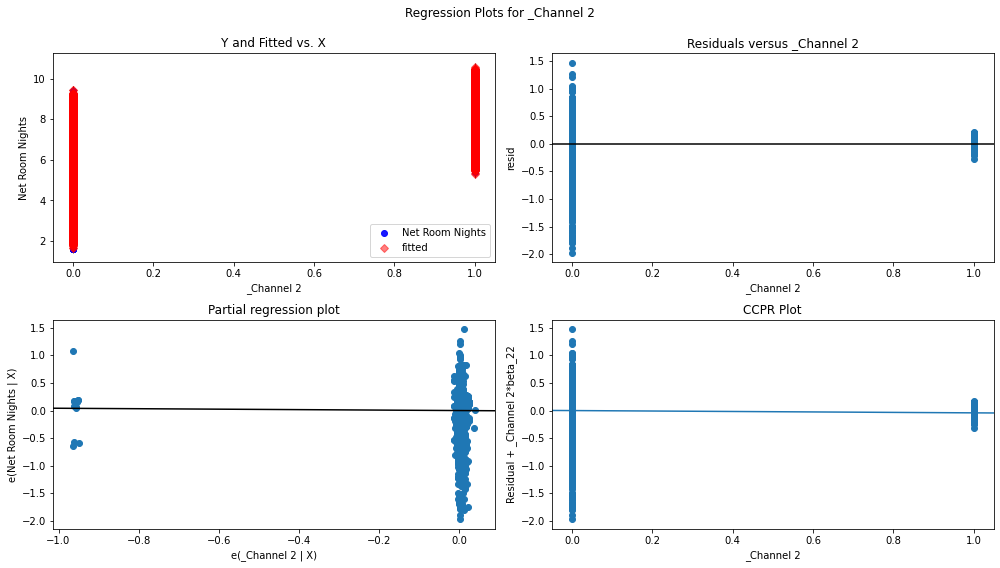

In [56]:
fig = plt.figure(figsize=(14, 8))
  
# creating regression plots
fig = sm.graphics.plot_regress_exog(result, '_Channel 2', fig=fig)

#### **XGboost Regression**

In [57]:
X = df_prep[["_Channel 2","_Channel 10","Bounce_rate","_Channel 4","Order_rate","_Desktop","_Geo Region 1","Potential_rate","_Channel 3"]]
y = df_prep['Net Room Nights']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 100)

In [58]:
xgb = XGBRegressor(n_estimators=1000, max_depth=20, subsample=0.7, colsample_bytree=0.8)
xgb.fit(X_train, y_train)
yhat_xgb = xgb.predict(X_test)

In [59]:
print("Coefficients:")
print(xgb.feature_importances_)
print(X.columns)
# print(xgb.summary())

Coefficients:
[0.392842   0.3332751  0.01933342 0.07804904 0.03439133 0.05331421
 0.04282787 0.0136972  0.03226991]
Index(['_Channel 2', '_Channel 10', 'Bounce_rate', '_Channel 4', 'Order_rate',
       '_Desktop', '_Geo Region 1', 'Potential_rate', '_Channel 3'],
      dtype='object')


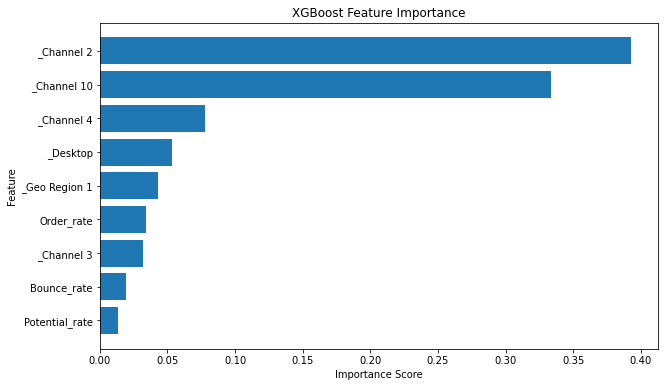

In [62]:
importance_scores = xgb.feature_importances_

feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_scores})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Plot the feature importance chart
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.show()